In [1]:
# Import the libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import nltk
import re
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
import lightgbm

In [2]:
# For reading stock data from yahoo
from pandas_datareader.data import DataReader
# For time stamps
from datetime import datetime

In [3]:
# Load the first dataset
columns=['Date','Category','News']
ndf = pd.read_csv("india-news-headlines.csv",names=columns)

In [4]:
print('Showing part of the whole dataset:')
ndf.head(5)

Showing part of the whole dataset:


,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [5]:
ndf.drop(0, inplace=True)
ndf.drop('Category', axis = 1, inplace=True)
print('Showing part of the whole dataset:')
ndf.head(-5)

Showing part of the whole dataset:


,Date,News
1,20010102,Status quo will not be disturbed at Ayodhya; s...
2,20010102,Fissures in Hurriyat over Pak visit
3,20010102,America's unwanted heading for India?
4,20010102,For bigwigs; it is destination Goa
5,20010102,Extra buses to clear tourist traffic
...,...,...
51625,20011210,Farmers to defy govt order on cane transport
51626,20011210,Kesco workers felicitated
51627,20011210,Dissidents did not meet Daljit Singh: MSR
51628,20011210,21-member dacoit gang nabbed


In [7]:
# Load the second dataset
hisdf = pd.read_csv("AAPL.csv")
hisdf.head(-5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-06-04,47.910000,48.355000,47.837502,47.957500,45.831806,105064800
1,2018-06-05,48.267502,48.485001,48.090000,48.327499,46.185394,86264000
2,2018-06-06,48.407501,48.520000,47.980000,48.494999,46.345470,83734400
3,2018-06-07,48.535000,48.549999,48.084999,48.365002,46.221241,85388800
4,2018-06-08,47.792500,48.000000,47.442501,47.924999,45.800743,106627200
...,...,...,...,...,...,...,...
1248,2023-05-18,173.000000,175.240005,172.580002,175.050003,175.050003,65496700
1249,2023-05-19,176.389999,176.389999,174.940002,175.160004,175.160004,55772400
1250,2023-05-22,173.979996,174.710007,173.449997,174.199997,174.199997,43570900
1251,2023-05-23,173.130005,173.380005,171.279999,171.559998,171.559998,50747300


In [10]:
# Check for common information of the first datast
ndf["Date"] = pd.to_datetime(ndf["Date"],format='%Y%m%d',errors='coerce')
ndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51634 entries, 1 to 51634
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    51633 non-null  datetime64[ns]
 1   News    51633 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 806.9+ KB


In [11]:
# Group the headlines for each day
ndf['News'] = ndf.groupby(['Date']).transform(lambda x : ' '.join(x)) 
ndf = ndf.drop_duplicates() 
ndf.reset_index(inplace=True,drop=True)

In [12]:
ndf

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
297,2001-12-07,Armed forces get a pat from Governor; CM Miffe...
298,2001-12-08,Abhinav memorial chess tournament Sunny side u...
299,2001-12-09,Chrysanthemum; Coleus Show gets underway Demon...
300,2001-12-10,Blending will improve performance of vehicles ...


In [13]:
# Check for any duplicated values
ndf.isnull().sum()

Date    1
News    1
dtype: int64

In [14]:
len(ndf)

302

In [15]:
hisdf=hisdf[["Date","Open","High","Low","Close","Volume"]]
hisdf.head(-5)

,Date,Open,High,Low,Close,Volume
0,2018-06-04,47.910000,48.355000,47.837502,47.957500,105064800
1,2018-06-05,48.267502,48.485001,48.090000,48.327499,86264000
2,2018-06-06,48.407501,48.520000,47.980000,48.494999,83734400
3,2018-06-07,48.535000,48.549999,48.084999,48.365002,85388800
4,2018-06-08,47.792500,48.000000,47.442501,47.924999,106627200
...,...,...,...,...,...,...
1248,2023-05-18,173.000000,175.240005,172.580002,175.050003,65496700
1249,2023-05-19,176.389999,176.389999,174.940002,175.160004,55772400
1250,2023-05-22,173.979996,174.710007,173.449997,174.199997,43570900
1251,2023-05-23,173.130005,173.380005,171.279999,171.559998,50747300


In [16]:
# Check for common information of the second dataset
hisdf["Date"]= pd.to_datetime(hisdf["Date"])
hisdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1258 non-null   datetime64[ns]
 1   Open    1258 non-null   float64       
 2   High    1258 non-null   float64       
 3   Low     1258 non-null   float64       
 4   Close   1258 non-null   float64       
 5   Volume  1258 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 59.1 KB


In [17]:
hisdf.describe()

,Open,High,Low,Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,107.346358,108.645926,106.134273,107.452486,1.107233e+08
std,45.855493,46.412358,45.329211,45.899092,5.461255e+07
min,35.994999,36.430000,35.500000,35.547501,3.519590e+07
25%,55.558127,56.092501,54.928749,55.705625,7.505678e+07
50%,121.145001,123.105000,119.635002,121.145000,9.596820e+07
75%,148.037495,149.537506,146.530002,148.257500,1.297685e+08
max,182.630005,182.940002,179.119995,182.009995,4.265100e+08


In [18]:
# Check for duplicated values
hisdf.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [19]:
len(hisdf)

1258

Text(0, 0.5, 'BSESN')

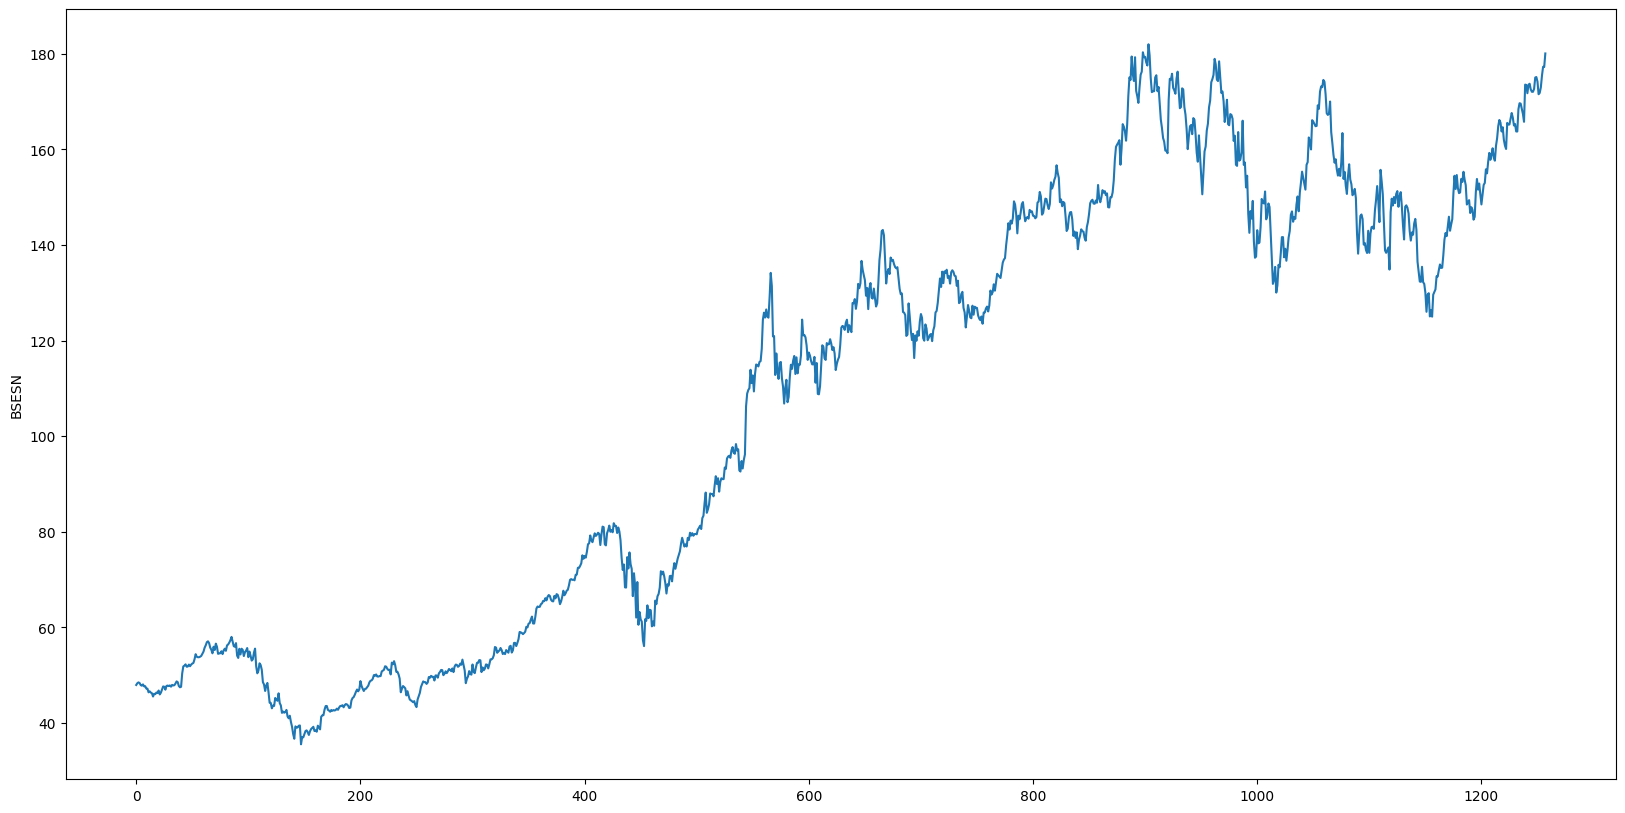

In [20]:
# Figure plot
plt.figure(figsize=(20,10))
hisdf['Close'].plot()
plt.ylabel('BSESN')

In [21]:
#removing unwanted characters from the News
ndf.replace("[^a-zA-Z']"," ",regex=True,inplace=True)
ndf["News"].head(5)

0    Status quo will not be disturbed at Ayodhya  s...
1    Powerless north India gropes in the dark Think...
2    The string that pulled Stephen Hawking to Indi...
3    Light combat craft takes India into club class...
4    Light combat craft takes India into club class...
Name: News, dtype: object

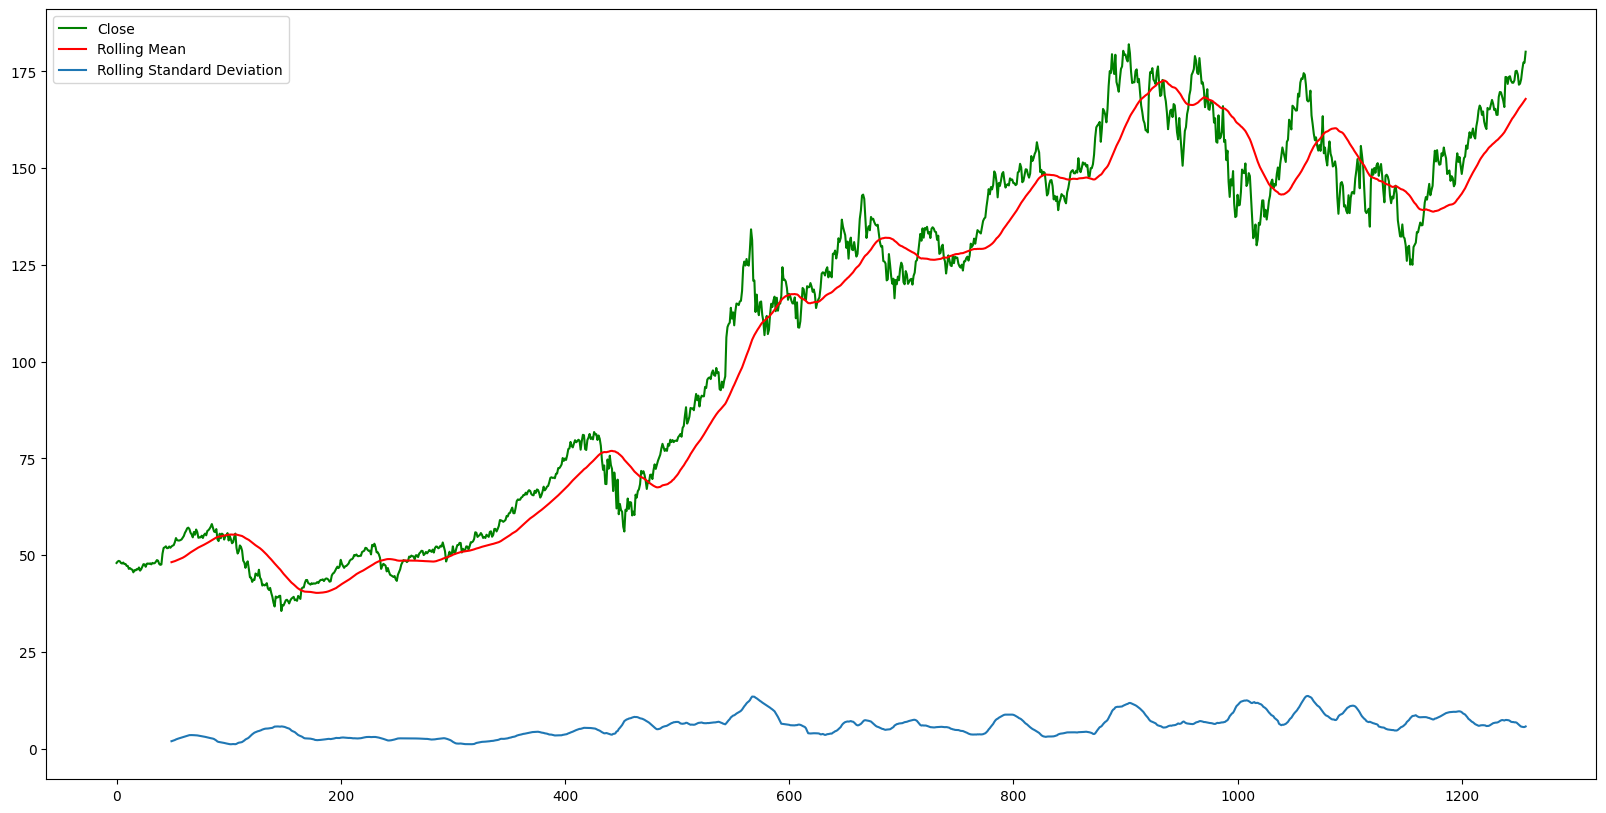

In [22]:
#Plotting moving average
close = hisdf['Close']

ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(20,10))
hisdf['Close'].plot(color='g',label='Close')
ma.plot(color = 'r',label='Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')

plt.legend()

Text(0.5, 1.0, 'Returns')

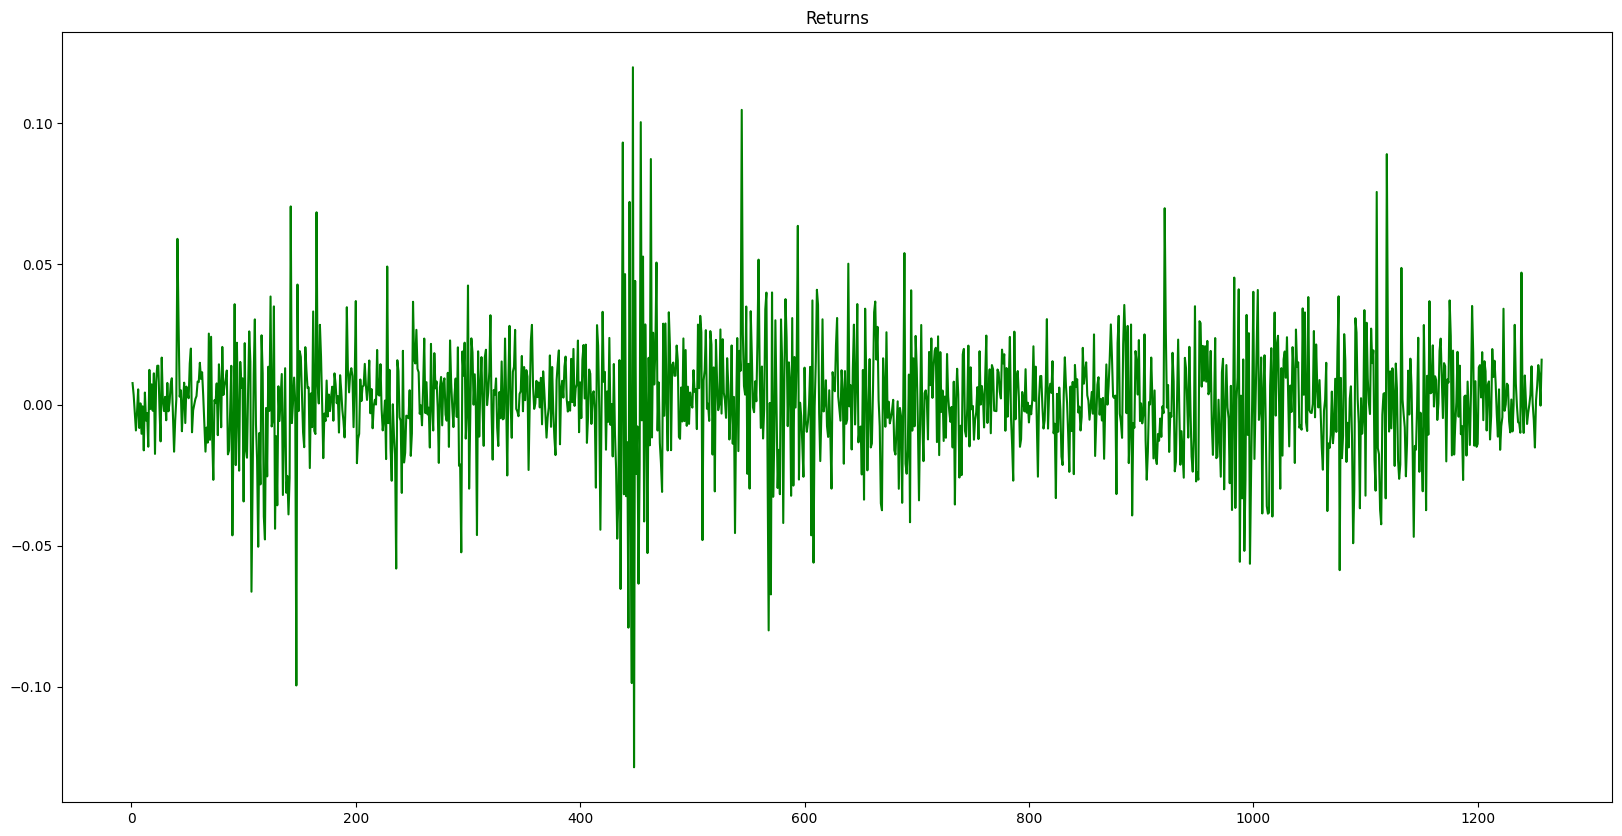

In [23]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (20,10))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [24]:
# Train test split
train = hisdf[:1219]
test = hisdf[1219:]

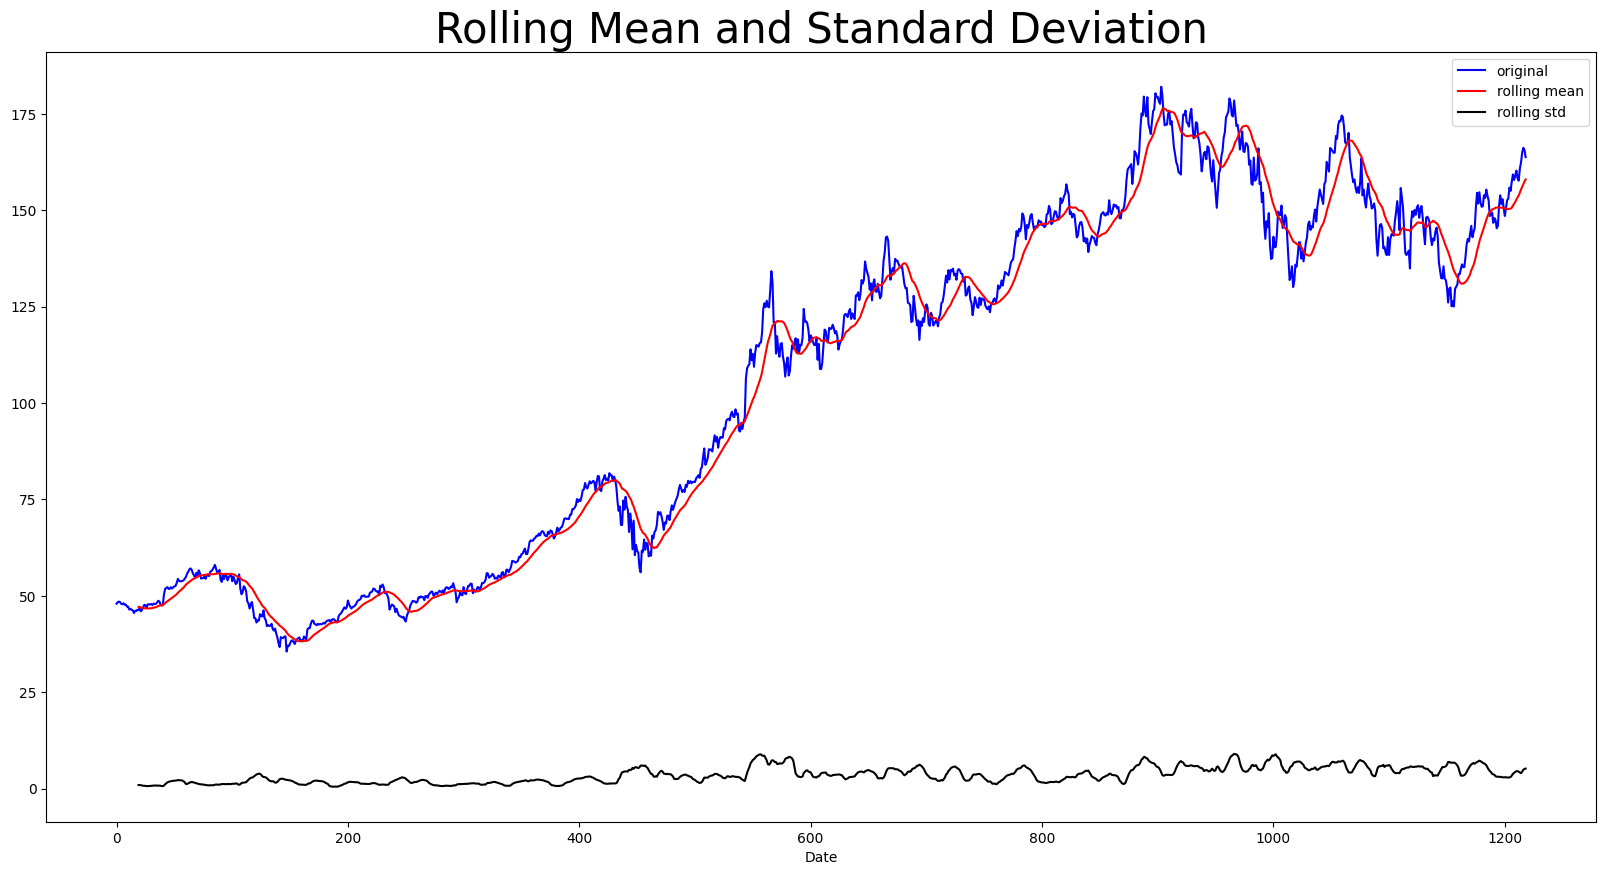

Results of dickey fuller test
ADF Test Statistic : -0.8236049106716666
p-value : 0.8120897870383288
#Lags Used : 1
Number of Observations Used : 1217
Weak evidence against null hypothesis, time series is non-stationary 


In [28]:
from statsmodels.tsa.stattools import adfuller
#Stationarity test
def test_stationarity(timeseries):

 #Determine the rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (20,10))
 plt.plot(timeseries, color = 'blue', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'black', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 30)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

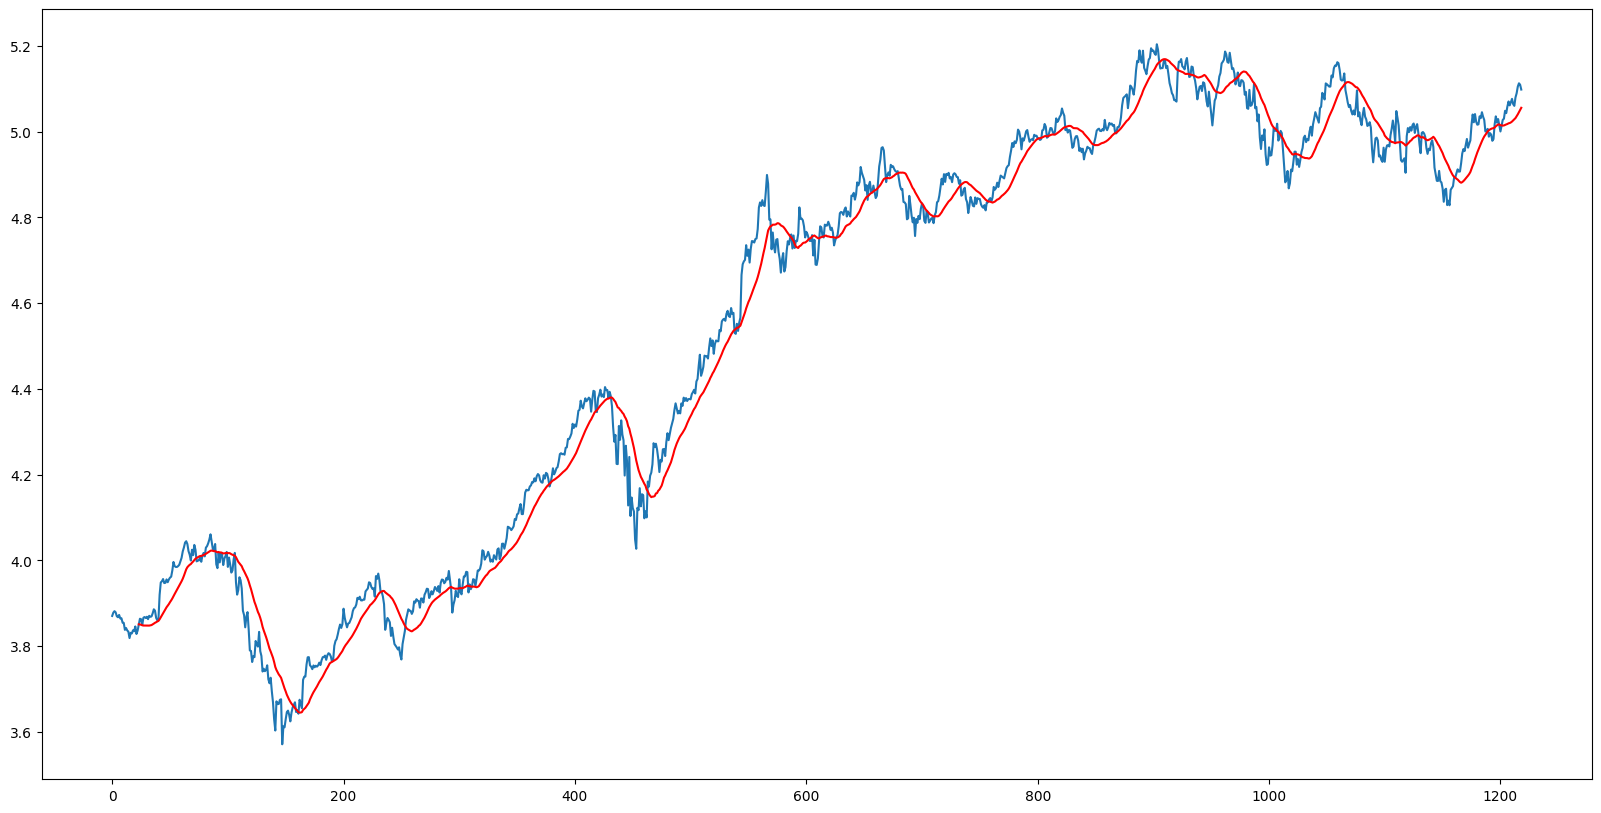

In [29]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (20,10))
plt.plot(train_log) 
plt.plot(mav, color = 'red')

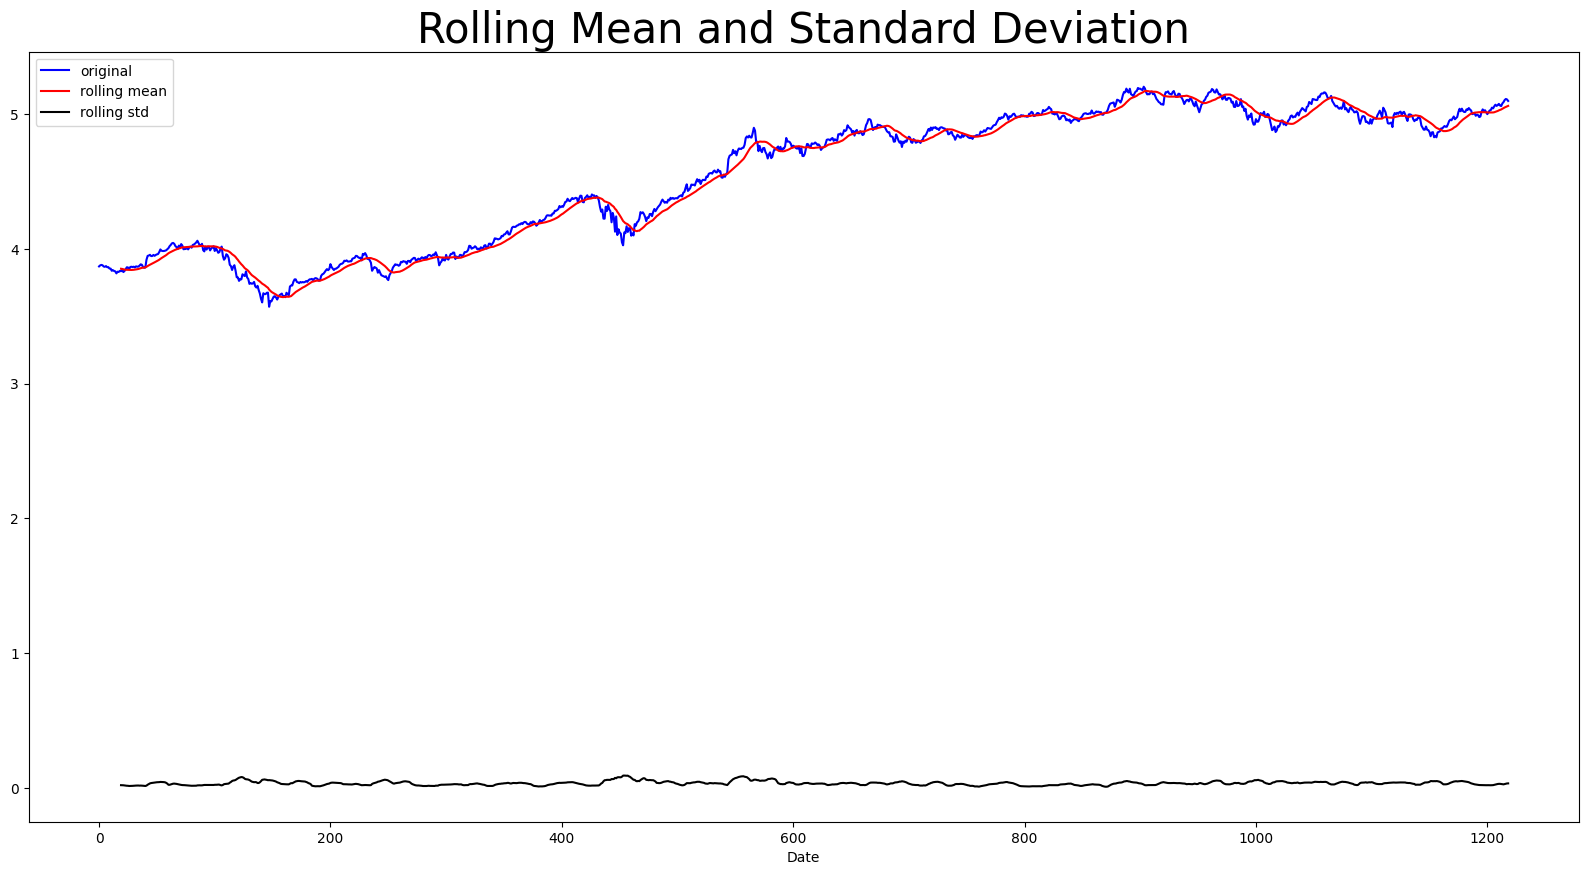

Results of dickey fuller test
ADF Test Statistic : -0.9960699805003188
p-value : 0.7546949852347267
#Lags Used : 9
Number of Observations Used : 1209
Weak evidence against null hypothesis, time series is non-stationary 


In [30]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

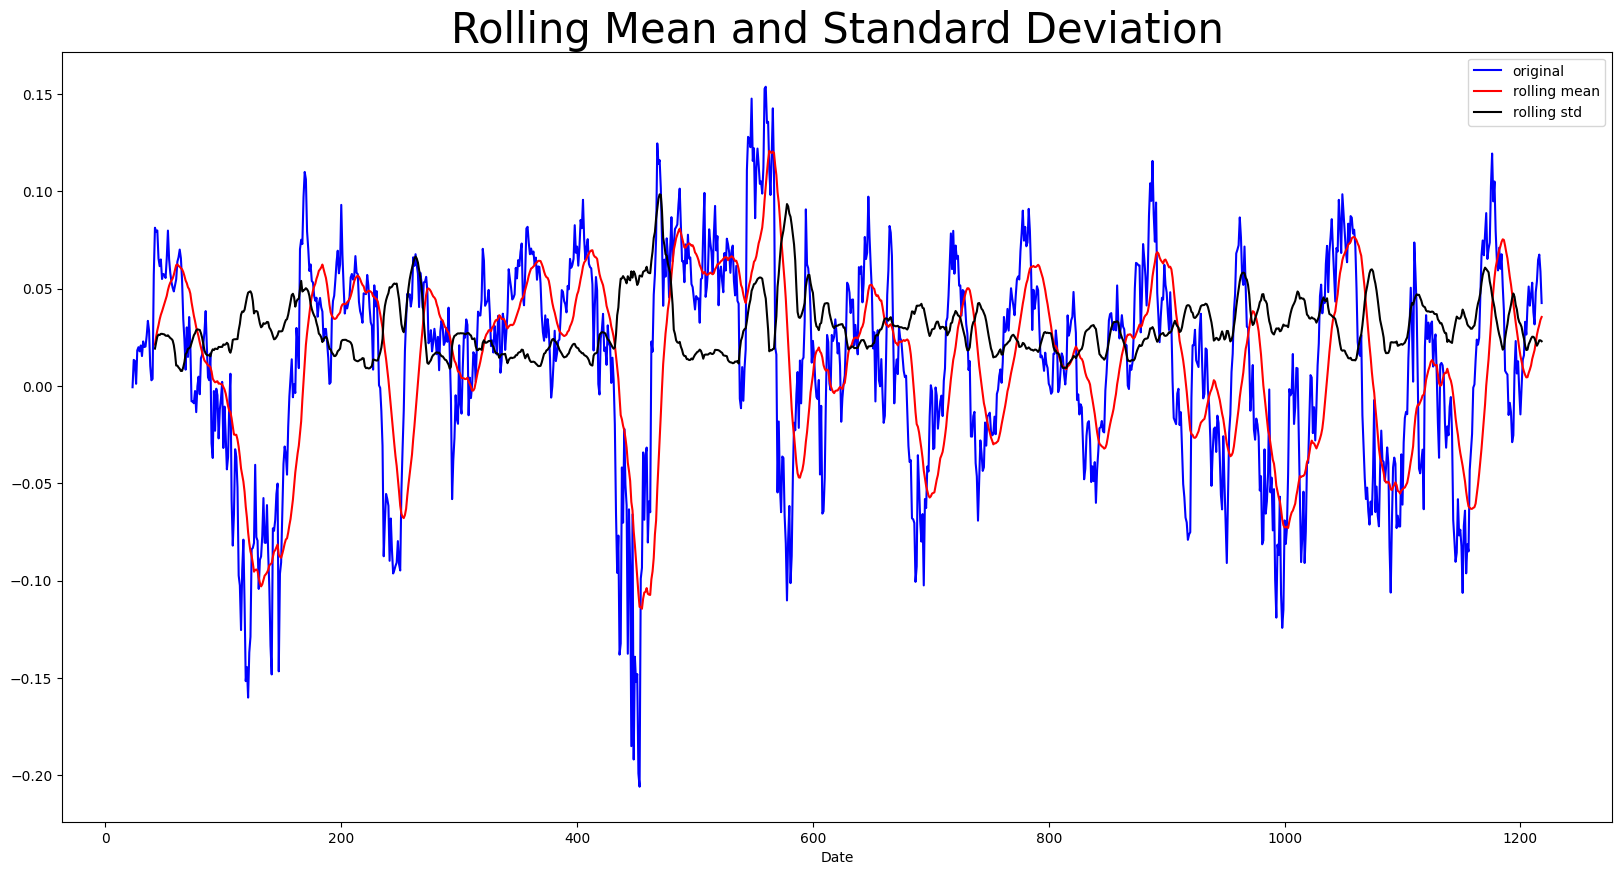

Results of dickey fuller test
ADF Test Statistic : -6.338256930569628
p-value : 2.795742110274684e-08
#Lags Used : 9
Number of Observations Used : 1186
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [32]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)
test_stationarity(train_log_diff)

In [34]:
#Using auto arima to make predictions using log data
!pip install pmdarima
from pmdarima import auto_arima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.1 MB/s eta 0:00:00


In [35]:
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5935.393, Time=6.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5925.565, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5940.965, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5941.042, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5924.816, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5939.043, Time=1.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5939.033, Time=0.71 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5937.058, Time=2.42 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5939.454, Time=0.51 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 12.516 seconds


Text(0, 0.5, 'Actual Stock Price')

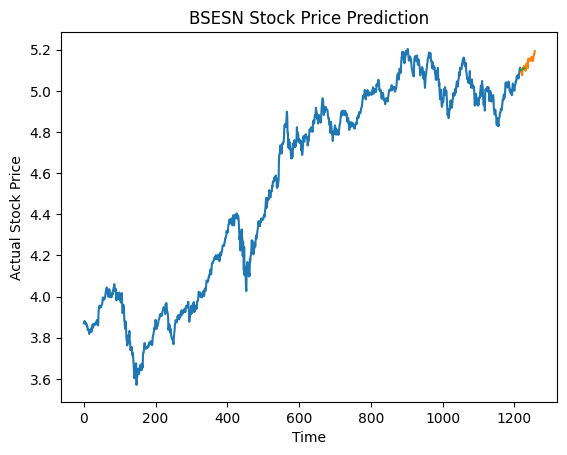

In [36]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

In [39]:
test_log = np.nan_to_num(test_log)
predictions = np.nan_to_num(predictions)
#Calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

RMSE :  4.436110348921434


In [40]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [44]:
from textblob import TextBlob
import pandas as pd
def getSubjectivity(text):
    if pd.isnull(text):  # Check if text is NaN
        return 0
def getPolarity(text):
    if pd.isnull(text):  # Check if text is NaN
        return 0

#Adding subjectivity and polarity columns
ndf['Subjectivity'] = ndf['News'].apply(getSubjectivity)
ndf['Polarity'] = ndf['News'].apply(getPolarity)
ndf

,Date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,NaN,NaN
1,2001-01-03,Powerless north India gropes in the dark Think...,NaN,NaN
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,NaN,NaN
3,2001-01-05,Light combat craft takes India into club class...,NaN,NaN
4,2001-01-06,Light combat craft takes India into club class...,NaN,NaN
...,...,...,...,...
297,2001-12-07,Armed forces get a pat from Governor CM Miffe...,NaN,NaN
298,2001-12-08,Abhinav memorial chess tournament Sunny side u...,NaN,NaN
299,2001-12-09,Chrysanthemum Coleus Show gets underway Demon...,NaN,NaN
300,2001-12-10,Blending will improve performance of vehicles ...,NaN,NaN


In [46]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [52]:
ndf['Compound'] = [sia.polarity_scores(str(v))['compound'] if isinstance(v, str) else 0 for v in ndf['News']]
ndf['Negative'] = [sia.polarity_scores(str(v))['neg'] if isinstance(v, str) else 0 for v in ndf['News']]
ndf['Neutral'] = [sia.polarity_scores(str(v))['neu'] if isinstance(v, str) else 0 for v in ndf['News']]
ndf['Positive'] = [sia.polarity_scores(str(v))['pos'] if isinstance(v, str) else 0 for v in ndf['News']]
ndf

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,NaN,NaN,-0.9792,0.121,0.809,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,NaN,NaN,-0.8910,0.156,0.735,0.109
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,NaN,NaN,0.7543,0.104,0.792,0.104
3,2001-01-05,Light combat craft takes India into club class...,NaN,NaN,0.9645,0.142,0.694,0.164
4,2001-01-06,Light combat craft takes India into club class...,NaN,NaN,-0.8316,0.214,0.655,0.131
...,...,...,...,...,...,...,...,...
297,2001-12-07,Armed forces get a pat from Governor CM Miffe...,NaN,NaN,-0.9989,0.140,0.783,0.077
298,2001-12-08,Abhinav memorial chess tournament Sunny side u...,NaN,NaN,-0.9994,0.181,0.693,0.125
299,2001-12-09,Chrysanthemum Coleus Show gets underway Demon...,NaN,NaN,-0.9947,0.138,0.746,0.115
300,2001-12-10,Blending will improve performance of vehicles ...,NaN,NaN,0.5574,0.053,0.854,0.093


In [58]:
df_merge = pd.merge(hisdf, ndf, how='outer', on='Date')
df_merge

,Date,Open,High,Low,Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2018-06-04,47.910000,48.355000,47.837502,47.957500,105064800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-06-05,48.267502,48.485001,48.090000,48.327499,86264000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-06-06,48.407501,48.520000,47.980000,48.494999,83734400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-06-07,48.535000,48.549999,48.084999,48.365002,85388800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-06-08,47.792500,48.000000,47.442501,47.924999,106627200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555,2001-12-07,NaN,NaN,NaN,NaN,NaN,Armed forces get a pat from Governor CM Miffe...,NaN,NaN,-0.9989,0.140,0.783,0.077
1556,2001-12-08,NaN,NaN,NaN,NaN,NaN,Abhinav memorial chess tournament Sunny side u...,NaN,NaN,-0.9994,0.181,0.693,0.125
1557,2001-12-09,NaN,NaN,NaN,NaN,NaN,Chrysanthemum Coleus Show gets underway Demon...,NaN,NaN,-0.9947,0.138,0.746,0.115
1558,2001-12-10,NaN,NaN,NaN,NaN,NaN,Blending will improve performance of vehicles ...,NaN,NaN,0.5574,0.053,0.854,0.093


In [59]:
dfmerge1 = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]
dfmerge1

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,47.957500,NaN,NaN,NaN,NaN,NaN,NaN
1,48.327499,NaN,NaN,NaN,NaN,NaN,NaN
2,48.494999,NaN,NaN,NaN,NaN,NaN,NaN
3,48.365002,NaN,NaN,NaN,NaN,NaN,NaN
4,47.924999,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1555,NaN,NaN,NaN,-0.9989,0.140,0.783,0.077
1556,NaN,NaN,NaN,-0.9994,0.181,0.693,0.125
1557,NaN,NaN,NaN,-0.9947,0.138,0.746,0.115
1558,NaN,NaN,NaN,0.5574,0.053,0.854,0.093


In [60]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
if not dfmerge1.empty:  # Check if DataFrame is not empty
    scaled_data = scaler.fit_transform(dfmerge1)
    scaled_df = pd.DataFrame(scaled_data, columns=dfmerge1.columns)
else:
    # Handle empty DataFrame case
    scaled_df = pd.DataFrame()


In [61]:
df = pd.DataFrame(scaler.fit_transform(dfmerge1))
df.columns = dfmerge1.columns
df.index = dfmerge1.index
df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.084732,NaN,NaN,NaN,NaN,NaN,NaN
1,0.087258,NaN,NaN,NaN,NaN,NaN,NaN
2,0.088401,NaN,NaN,NaN,NaN,NaN,NaN
3,0.087514,NaN,NaN,NaN,NaN,NaN,NaN
4,0.084510,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
X=df.drop('Close',axis=1)
X

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1555,NaN,NaN,0.000503,0.315315,0.783,0.126645
1556,NaN,NaN,0.000251,0.407658,0.693,0.205592
1557,NaN,NaN,0.002615,0.310811,0.746,0.189145
1558,NaN,NaN,0.783232,0.119369,0.854,0.152961


In [63]:
Y=df['Close']
Y

0       0.084732
1       0.087258
2       0.088401
3       0.087514
4       0.084510
          ...   
1555         NaN
1556         NaN
1557         NaN
1558         NaN
1559         NaN
Name: Close, Length: 1560, dtype: float64

In [88]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
x_train.shape

(1248, 6)

In [89]:
x_train[:50]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
224,NaN,NaN,NaN,NaN,NaN,NaN
302,NaN,NaN,NaN,NaN,NaN,NaN
1108,NaN,NaN,NaN,NaN,NaN,NaN
218,NaN,NaN,NaN,NaN,NaN,NaN
1014,NaN,NaN,NaN,NaN,NaN,NaN
792,NaN,NaN,NaN,NaN,NaN,NaN
1088,NaN,NaN,NaN,NaN,NaN,NaN
295,NaN,NaN,NaN,NaN,NaN,NaN
526,NaN,NaN,NaN,NaN,NaN,NaN
920,NaN,NaN,NaN,NaN,NaN,NaN
